# Generative Adversarial Network (GAN)

**Authors: Thomas Pierrot & Baptiste Jorant**

*A short tutorial to explain and experiment how GANs work through easy examples. We will be using Pytorch during this notebook.*

##### First let's import some prerequisites, while you'll read the introduction.

In [1]:
%matplotlib inline

import itertools
import math
import time
import os

import numpy as np 
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable

In [2]:
# set batch_size
batch_size = 100

# the data, shuffled and split between train and test sets
# we normalize data to have values between -1 and 1
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) ])

train_dataset = dsets.MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
train_iterator = iter(train_loader)

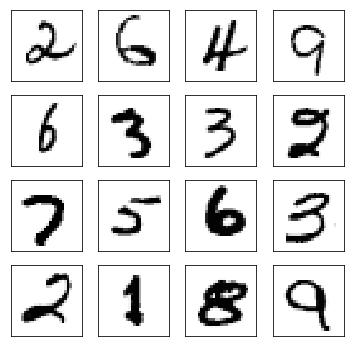

In [3]:
num_test_samples = 16 # number of digits to plot

# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# load a batch of training data
images, labels = next(train_iterator)

# show a subpart of it
for k in range(num_test_samples):
    i = k//4
    j = k%4
    ax[i,j].cla()
    ax[i,j].imshow(images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
    display.clear_output(wait=True)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_image = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3))
        self.fc_label = nn.Sequential(
            nn.Linear(1, 100),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.model = nn.Sequential(
            #nn.Linear(1124, 512),
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, image, label):
        image = image.view(image.size(0), 784)
        label = label.view(label.size(0), 10)
        #tmp1 = self.fc_image(image)
        #tmp2 = self.fc_label(label)
        tmp1 = image
        tmp2 = label
        x = torch.cat([tmp1, tmp2], 1)
        out = self.model(x)
        out = out.view(out.size(0), -1)
        return out

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_noise = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True))
        self.fc_label = nn.Sequential(
            nn.Linear(1, 100),
            nn.LeakyReLU(0.2, inplace=True))
        
        self.model = nn.Sequential(
            #nn.Linear(356, 512),
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, noise, label):
        noise = noise.view(noise.size(0), 100)
        label = label.view(label.size(0), 10)
        #tmp1 = self.fc_noise(noise)
        #tmp2 = self.fc_label(label)
        tmp1 = noise
        tmp2 = label
        x = torch.cat([tmp1, tmp2], 1)
        out = self.model(x)
        return out

Once the class are written, we instantiate the networks.

In [6]:
discriminator = Discriminator()
generator = Generator()

We also initialize the optimizers.

In [7]:
criterion = nn.BCELoss() #BCE standing for Binary Cross Entropy
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

And write both the discriminator and generator train functions.

In [8]:
def train_discriminator(discriminator, images, labels, ones, fake_images, fake_labels, zeros):
    discriminator.zero_grad()
    outputs = discriminator(images, labels)
    real_loss = criterion(outputs, ones)
    real_score = outputs
    
    outputs = discriminator(fake_images, fake_labels) 
    fake_loss = criterion(outputs, zeros)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [9]:
def train_generator(generator, discriminator_outputs, ones):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, ones)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

# Train the model!
The moment of truth : we will train GAN networks on our database. 

<div class="alert alert-danger">
<b> Warning :</b>
This operation will take some time, depending on the value of the batch and the number of epochs you defined, and on your computer performances.<br/>

In [10]:
# Prepare folder to store results
if not os.path.exists('results'):
    os.makedirs('results')
    
# Prepare folder to store models
if not os.path.exists('models'):
    os.makedirs('models')

In [11]:
# Draw samples from the input distribution to inspect the generation on training 
num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, 100))
labels_samples = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5], dtype=torch.float)
labels_samples = labels_samples.view(num_test_samples, 1)

In [12]:
def get_one_hot(targets, nb_classes):
    targets = targets.numpy()
    res = np.zeros((targets.shape[0],nb_classes))
    for i in range(targets.shape[0]):
        res[i,int(targets[i])]=1
    return torch.Tensor(res.reshape(list(targets.shape)+[nb_classes]))

In [13]:
# one hot encoding of labels samples for testing
labels_samples = get_one_hot(labels_samples, nb_classes=10)

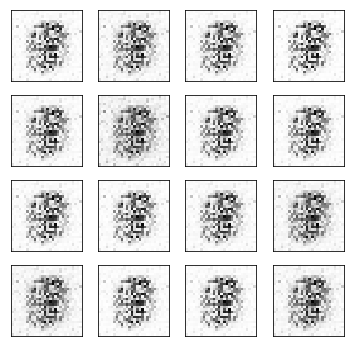

Epoch [1/50], Step[600/600], d_loss: 1.5163, g_loss: 1.4401, D(x): 0.46, D(G(z)): 0.40, time 2.40 min


In [ ]:
# Create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# Set number of epochs and initialize figure counter
num_epochs = 50
num_batches = len(train_loader)

# Set counter
num_fig = 0

# Start timer
t0 = time.time()

# Start training
for epoch in range(num_epochs):  
    for n, (images, labels) in enumerate(train_loader):
        # One hot encoding of labels
        labels = get_one_hot(labels, nb_classes=10)
        
        # Convert data to suitable format
        images = Variable(images)
        labels = Variable(labels.float())
        ones = Variable(torch.ones(images.size(0)))
        
        # Sample from generator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise, labels)
        zeros = Variable(torch.zeros(images.size(0)))
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, labels, ones, fake_images, labels, zeros)
        
        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), 100))
        fake_images = generator(noise, labels)
        outputs = discriminator(fake_images, labels)

        # Train the generator
        g_loss = train_generator(generator, outputs, ones)
        
        # Every half epoch generates pictures with to generator to monitor training
        if (n+1) % int(num_batches/2) == 0:
            # generate pictures
            test_images = generator(test_noise, labels_samples)
            
            # plot them
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            # save the picture
            plt.savefig('results/condi-mnist-gan-%03d.png'%num_fig)
            num_fig += 1
            # print log
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f, time %.2f min' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean(), (time.time()-t0)/60))
            
        # at the end of each epoch, save the models
        torch.save(generator.state_dict(), os.path.join('models', 'generator.pkl'))
        torch.save(discriminator.state_dict(), os.path.join('models', 'discriminator.pkl'))